In [3]:
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
bucket = Session().default_bucket()

In [4]:
%%time
import pickle, gzip, numpy, boto3, json

# Load the dataset
region = boto3.Session().region_name
boto3.Session().resource('s3', region_name=region).Bucket('sagemaker-sample-data-{}'.format(region)).download_file('algorithms/kmeans/mnist/mnist.pkl.gz', 'mnist.pkl.gz')
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 951 ms, sys: 316 ms, total: 1.27 s
Wall time: 1.41 s


In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [6]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-us-east-1-367854818590/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-367854818590/kmeans_example/output


In [17]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

RuntimeError: DataDistribution: ShardedByS3Key is not currently supported in Local Mode

In [8]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!CPU times: user 491 ms, sys: 16.8 ms, total: 507 ms
Wall time: 8min 20s


In [9]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 5.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 7.294848442077637
    }
  }
}
]


In [10]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 23.9 ms, sys: 0 ns, total: 23.9 ms
Wall time: 125 ms





Cluster 0:


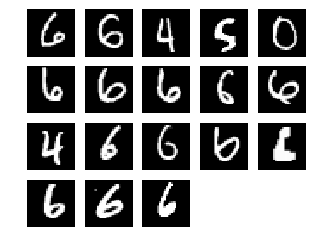




Cluster 1:


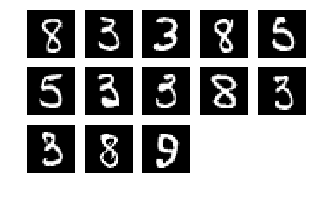




Cluster 2:


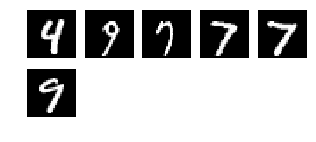




Cluster 3:


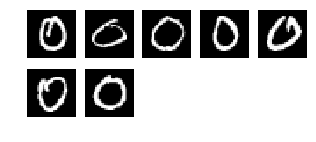




Cluster 4:


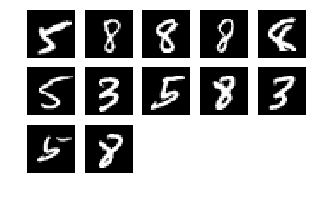




Cluster 5:


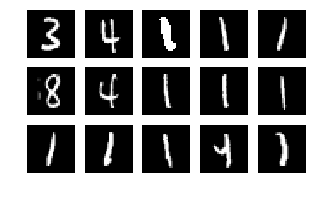




Cluster 6:


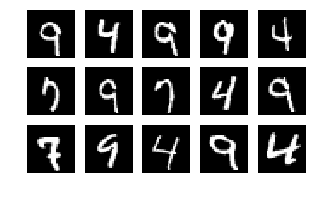




Cluster 7:


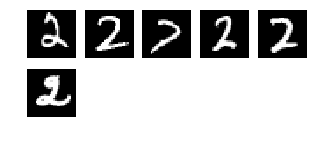




Cluster 8:


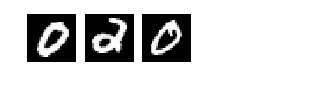




Cluster 9:


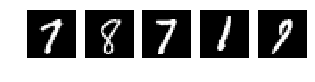

In [11]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [12]:
print(kmeans_predictor.endpoint)

kmeans-2019-11-24-20-18-39-742


In [ ]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)